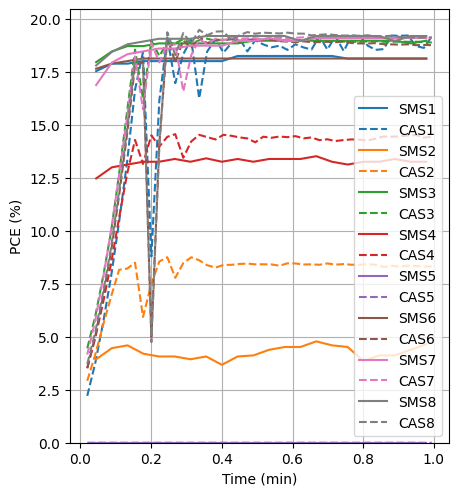

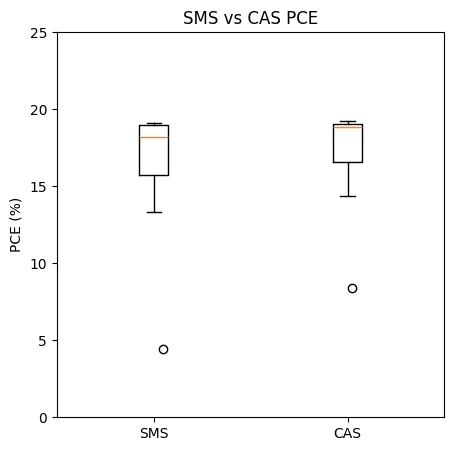

min diff: 0.007020526159273288 at idx: 2
Average PCE absolute difference: 0.939523396184935
Average PCE diff across device: 0.9375175315679982

total_diff 0.939523396184935
total device diff 0.9375175315679982


In [28]:
# %matplotlib widget

import matplotlib.pyplot as plt
import numpy as np
import numpy_indexed as npi
from labellines import labelLines
from matplotlib.font_manager import FontProperties
import os
import sys
import re
np.set_printoptions(threshold=sys.maxsize)
from matplotlib.cbook import boxplot_stats

def get_outlier_indices(data):
	data = np.asarray(data)
	q1 = np.percentile(data, 25)
	q3 = np.percentile(data, 75)
	iqr = q3 - q1

	lower_bound = q1 - 1.5 * iqr
	upper_bound = q3 + 1.5 * iqr

	outlier_mask = (data < lower_bound) | (data > upper_bound)
	return np.where(outlier_mask)[0]

def detect_settled_index(t, P, window, thresh):
	t = np.asarray(t, dtype=float)
	P = np.asarray(P, dtype=float)

	# --- rest of your function unchanged --------------------
	for start in np.arange(t[0], t[-1] - window, window):
		end   = start + window
		mask  = (t >= start) & (t <= end)
		if mask.sum() < 2:
			continue
		segment   = P[mask]		  # now works: P is an ndarray
		mean_seg  = segment.mean()
		if mean_seg == 0:
			continue
		if np.abs(segment - mean_seg).max() < thresh * mean_seg:
			return np.where(t >= start)[0][0]   # first index in settled window
	return None

def plot_current(mA_density, cas_mA, time_label, ss_file_path, time, cas_directory, cas_time):
	bottom = min(np.min(mA_density), np.min(cas_mA))*0.95
	top = max(np.max(mA_density), np.max(cas_mA))*1.05

	plt.figure(figsize=plot_size)
	plt.ylim(bottom = bottom, top = top)
	plt.xlabel(time_label)
	plt.grid()
	plt.ylabel('Current Density (mA / cm^2)')
	plt.subplots_adjust(left=0.086,
						bottom=0.06,
						right=0.844,
						top=0.927,
						wspace=0.2,
						hspace=0.2)
	colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

	for i in plot_range:
		lineName = "mA" + str(i + 1)
		if ss_file_path:
			plt.plot(time,
						mA_density[:,i],

						color=colors[i % len(colors)],
						label = "SMS"+ str(i+1))
		if cas_directory:
			plt.plot(cas_time[i],
						cas_mA[i],
						linestyle='--',
						color=colors[i % len(colors)],
						label = "CAS")

	# plt.legend(bbox_to_anchor=legend_anchor)
	plt.legend()
	plt.show()

def plot_voltage(v, cas_V, time_label, ss_file_path, time, cas_directory, cas_time):
	plt.figure(figsize=plot_size)
	bottom = min(np.min(v), np.min(cas_V))*0.95
	top = max(np.max(v), np.max(cas_V))*1.05
	plt.ylim(bottom = bottom, top = top)
	plt.xlabel(time_label)
	plt.grid()
	plt.ylabel('Voltage (V)')
	plt.subplots_adjust(left=0.086,
						bottom=0.06,
						right=0.844,
						top=0.927,
						wspace=0.2,
						hspace=0.2)
	colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

	for i in plot_range:
		lineName = "V" + str(i + 1)
		if ss_file_path:
			plt.plot(time,
					 v[:,i],

					 color=colors[i % len(colors)],
					 label = "SMS"+ str(i+1))
		if cas_directory:
			plt.plot(cas_time[i],
					 cas_V[i],
					 linestyle='--',
					 color=colors[i % len(colors)],
					 label = "CAS")
	# plt.legend(bbox_to_anchor=legend_anchor)
	plt.legend()
	plt.show()

def plot_difference(cas_directory = "", ss_file_path = "", plot_range = [], time_limit = -1, plot_size = (12,10), remove_outliers = False, roll = 0, plot = True):
	all_files = []
	cell_area = 0
	if ss_file_path != "":
		arr = np.loadtxt(ss_file_path, delimiter=",", dtype=str)
		header_row = np.where(arr == "Time")[0][0]

		meta_data = {}
		for data in arr[:header_row, :2]:
			meta_data[data[0]] = data[1]
		cell_area= float(meta_data["Cell Area (mm^2)"])

	if cas_directory != "":
		for root, dirs, files in os.walk(cas_directory):
			for file in files:
				if file.endswith('.csv'):
					file_path = os.path.join(root, file)
					all_files.append(file_path)

	cas_pce = []
	cas_V = []
	cas_mA = []
	cas_time = []

	# Process each file
	for file_path in all_files:
		if "_5_0" in file_path:
			try:
				data = np.genfromtxt(
					file_path,
					delimiter=',',
					comments='#',
					skip_header=0,
					encoding='cp1252'  # Specify the correct encoding
				)
				pce = ((data[:, 1] * (data[:, 2]/1000)) / (0.1*cell_area))*100
				# data_with_pce= np.column_stack((data, pce))
				cas_V.append(data[:, 1])
				cas_mA.append(data[:, 2]/cell_area)
				cas_time.append(data[:,0])
				cas_pce.append(pce)
			except Exception as e:
				print(f"Error processing {file_path}: {e}")

	cas_pce = np.array(cas_pce[::-1])
	cas_time = np.array(cas_time[::-1])
	cas_mA = np.array(cas_mA[::-1])
	cas_V = np.array(cas_V[::-1])
	cas_time = cas_time/60
	if cas_directory:
		max_time = np.max(cas_time[0])
		if max_time > time_limit and time_limit > 0:
			end_idx = np.searchsorted(cas_time[0,:], time_limit)

			cas_time = cas_time[:, :end_idx]
			cas_pce = cas_pce[:, :end_idx]
			cas_mA = cas_mA[:, :end_idx]
			cas_V = cas_V[:, :end_idx]
	else:
		cas_mA = [0]
		cas_V = [0]
		cas_pce = [0]


	data = []
	mA_density = []
	v = []
	cell_area = 0
	# ss_file_path = ""
	# ss_file_path = r"C:\Users\achen\Dropbox\code\Stability-Setup\data\Mar-4-2025 4 device test\Mar-04-2025 16_42_19__4 Device First Test\Mar-04-2025_16-44-53__4 Device First Test__ID2__mppt.csv"
	if ss_file_path != "":
		arr = np.loadtxt(ss_file_path, delimiter=",", dtype=str)
		header_row = np.where(arr == "Time")[0][0]

		meta_data = {}
		for data in arr[:header_row, :2]:
			meta_data[data[0]] = data[1]

		headers = arr[header_row, :]
		arr = arr[header_row + 1 :, :]

		header_dict = {value: index for index, value in enumerate(headers)}
		time = np.array(arr[:, header_dict["Time"]]).astype("float")
		time /= 60

		pixel_V = arr[:, 1::2][:, 0:8].astype(float)
		pixel_mA = arr[:, 2::2][:, 0:8].astype(float)
		pixel_V = np.roll(pixel_V, roll, axis = 1)
		pixel_mA = np.roll(pixel_mA, roll, axis = 1)

		cell_area = float(meta_data["Cell Area (mm^2)"])
		mA_density = pixel_mA/cell_area

		v = pixel_V

		data = ((pixel_V*pixel_mA/1000) / (0.1*cell_area))*100

		# calculation in minutes
		max_time = time[-1]
		if max_time > time_limit and time_limit > 0:
			end_idx = np.searchsorted(time, time_limit)
			time = time[:end_idx]
			data = data[:end_idx,:]
			mA_density = mA_density[:end_idx,:]
			v = pixel_V[:end_idx,:]
	time_label = "Time (min)"
	if max(time) > 60:
		time /= 60
		cas_time /= 60
		time_label = "Time (hr)"

	average_cas = []
	average_sms = []
	if plot:
		plt.figure(figsize=plot_size)
		bottom = min(np.min(cas_pce), np.min(data))*0.95
		top = max(np.max(cas_pce), np.max(data))*1.05

		plt.ylim(bottom = 0, top = top)
		plt.xlabel(time_label)
		plt.grid()
		colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

		plt.ylabel('PCE (%)')
		plt.subplots_adjust(left=0.086,
							bottom=0.06,
							right=0.844,
							top=0.927,
							wspace=0.2,
							hspace=0.2)
	for i in plot_range:
		if ss_file_path and plot:
			plt.plot(time,
					data[:,i],
					color=colors[i % len(colors)],
					label = "SMS"+ str(i+1))
		if cas_directory and plot:
			plt.plot(cas_time[i],
					cas_pce[i],
					linestyle='--',
					color=colors[i % len(colors)],
					label = "CAS"+ str(i+1))
		if ss_file_path and cas_directory:
			second_half = data[:,i][len(data[:,i]) // 2:]
			average_second_half = np.mean(second_half)

			second_half_cas = cas_pce[i][len(cas_pce[i]) // 2:]
			average_second_half_cas = np.mean(second_half_cas)
			if average_second_half > 2.5 and average_second_half_cas > 2.5:
				average_sms.append(average_second_half)
				average_cas.append(average_second_half_cas)

		if plot:
			lines = plt.gca().get_lines()
			x_min, x_max = plt.xlim()
			num_lines = len(lines)
		# legend_anchor = (1, 0.2)
		# plt.legend(bbox_to_anchor=legend_anchor)
	if plot:
		plt.legend()
		plt.savefig(
			"MPPT_Plot.png",         # output filename (extension defines format)
			dpi=300,               # resolution in dots per inch
		)
		# plt.show()

	# plot_current(mA_density, cas_mA, time_label, ss_file_path, time, cas_directory, cas_time)
	# plot_voltage(v, cas_V, time_label, ss_file_path, time, cas_directory, cas_time)



	average_sms = np.array(average_sms)
	average_cas = np.array(average_cas)
	abs_diff = abs(average_sms - average_cas)

	try:
		sms_outliers = get_outlier_indices(average_sms)
		cas_outliers = get_outlier_indices(average_cas)
		outliers = np.unique(np.concatenate((sms_outliers, cas_outliers)))
	except:
		outliers = []
	filtered_sms = np.delete(average_sms, outliers)
	filtered_cas = np.delete(average_cas, outliers)
	filtered_diff = abs(filtered_sms-filtered_cas)

	# Plot the boxplot
	# if filtered:
		# box_plot = [filtered_sms, filtered_cas]
	# elif not filtered:

	if plot:
		box_plot = [average_sms, average_cas]
		labels = ["SMS", "CAS"]

		# Optional: compute stats using matplotlib's utility
		stats = boxplot_stats(box_plot)
		fig, ax = plt.subplots(figsize=plot_size)
		bp = ax.boxplot(box_plot, flierprops=dict(marker='o', markersize=0))
		ax.set_ylim(0, 25)

		for i, stat in enumerate(stats, start=1):
			outliers = stat['fliers']  # already identified!

			if len(outliers) > 0:
				jitter = 0.2 * (np.random.rand(len(outliers)) - 0.5)  # random horizontal spread
				x_positions = np.full(len(outliers), i) + jitter
				ax.scatter(x_positions, outliers, color='white', edgecolor='black', zorder=3)

		# Label the x-axis
		ax.set_xticks([1, 2])
		ax.set_title("SMS vs CAS PCE")
		ax.set_ylabel("PCE (%)")
		ax.set_xticklabels(labels)
		plt.show()


	if remove_outliers:
		return filtered_diff, filtered_sms, filtered_cas
	else:
		return abs_diff, average_sms, average_cas

r"""
Best

cas search = _5_0

for i in range(1,5):
	files.append([
		rf"C:\Users\Andrew Chen\Dropbox\code\Stability-Setup\data\April-03-2025 cas\devices\{i}",
		rf"C:\Users\Andrew Chen\Dropbox\code\Stability-Setup\data\Apr-03-2025 19_41_27\Apr-03-2025_19-57-33__ID{i}__mppt.csv"
	])

"""

# # TRIAL WITH CAS HOLDER
sms_files = [
    # rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\Apr-03-2025 19_41_27\Apr-03-2025_19-57-33__ID1__mppt.csv",
    rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\Apr-03-2025 19_41_27\Apr-03-2025_19-57-33__ID2__mppt.csv",
    # rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\Apr-03-2025 19_41_27\Apr-03-2025_19-57-33__ID3__mppt.csv",
    # rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\Apr-03-2025 19_41_27\Apr-03-2025_19-57-33__ID4__mppt.csv",
]

cas_files = [
	# rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\Apr-03-2025 19_41_27\devices\1",
	rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\Apr-03-2025 19_41_27\devices\2",
	# rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\Apr-03-2025 19_41_27\devices\3",
	# rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\Apr-03-2025 19_41_27\devices\4",
]

# TRIAL WITH SAMPLE HOLDER
# sms_files = [
# 	rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\Apr-29-2025 17_25_13 leo devices\Apr-29-2025_17-27-31__ID1__mppt.csv",
# 	rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\Apr-29-2025 17_25_13 leo devices\Apr-29-2025_17-33-16__ID2__mppt.csv",
# 	rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\Apr-29-2025 17_25_13 leo devices\Apr-29-2025_17-33-16__ID3__mppt.csv",
# 	rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\Apr-29-2025 17_25_13 leo devices\Apr-29-2025_17-27-31__ID4__mppt.csv",
# ]
# cas_files = [
# 	rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\Apr-29-2025 17_25_13 leo devices\devices\1",
# 	rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\Apr-29-2025 17_25_13 leo devices\devices\2",
# 	rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\Apr-29-2025 17_25_13 leo devices\devices\3",
# 	rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\Apr-29-2025 17_25_13 leo devices\devices\4",
# ]

plot_range = [x for x in range(8)]
printouts = []
all_diff = []
average_sms = []
average_cas = []
average_diff_device = []
plot_size = (5,5)
for cas, ss_file in zip(cas_files, sms_files):
	abs_diff, temp_sms, temp_cas = plot_difference(cas, ss_file, plot_range, plot_size = plot_size, remove_outliers=False, roll = 0, time_limit = 1)
	sms = np.mean(temp_sms)
	cas = np.mean(temp_cas)
	device_diff = abs(sms - cas)
	average_diff_device.append(device_diff)

	all_diff.extend(abs_diff)
	average_sms.extend(temp_sms)
	average_cas.extend(temp_cas)
	# print("sms:" ,temp_sms)
	# print("lit:" ,temp_cas)
	if cas and ss_file:
		try:
			printouts.append([np.min(abs_diff), np.argmin(abs_diff), np.mean(abs_diff), device_diff])

		except:
			pass

average_sms = np.asarray(average_sms)
average_cas = np.asarray(average_cas)
average_diff = average_sms - average_cas


# # Print stats for each label
# for label, stat in zip(labels, stats):
#     print(f"--- {label} ---")
#     print(f"Min: {stat['whislo']}")
#     print(f"Q1 : {stat['q1']}")
#     print(f"Med: {stat['med']}")
#     print(f"Q3 : {stat['q3']}")
#     print(f"Max: {stat['whishi']}")
#     print(f"Outliers: {stat['fliers']}")
#     print()

for printout in printouts:
	print(f"min diff: {printout[0]} at idx: {printout[1]}")  # or arr.min()
	print(f"Average PCE absolute difference: {printout[2]}")
	print(f"Average PCE diff across device: {printout[3]}")
	print()
print(f"total_diff {np.mean(all_diff)}")
print(f"total device diff {np.mean(average_diff_device)}")




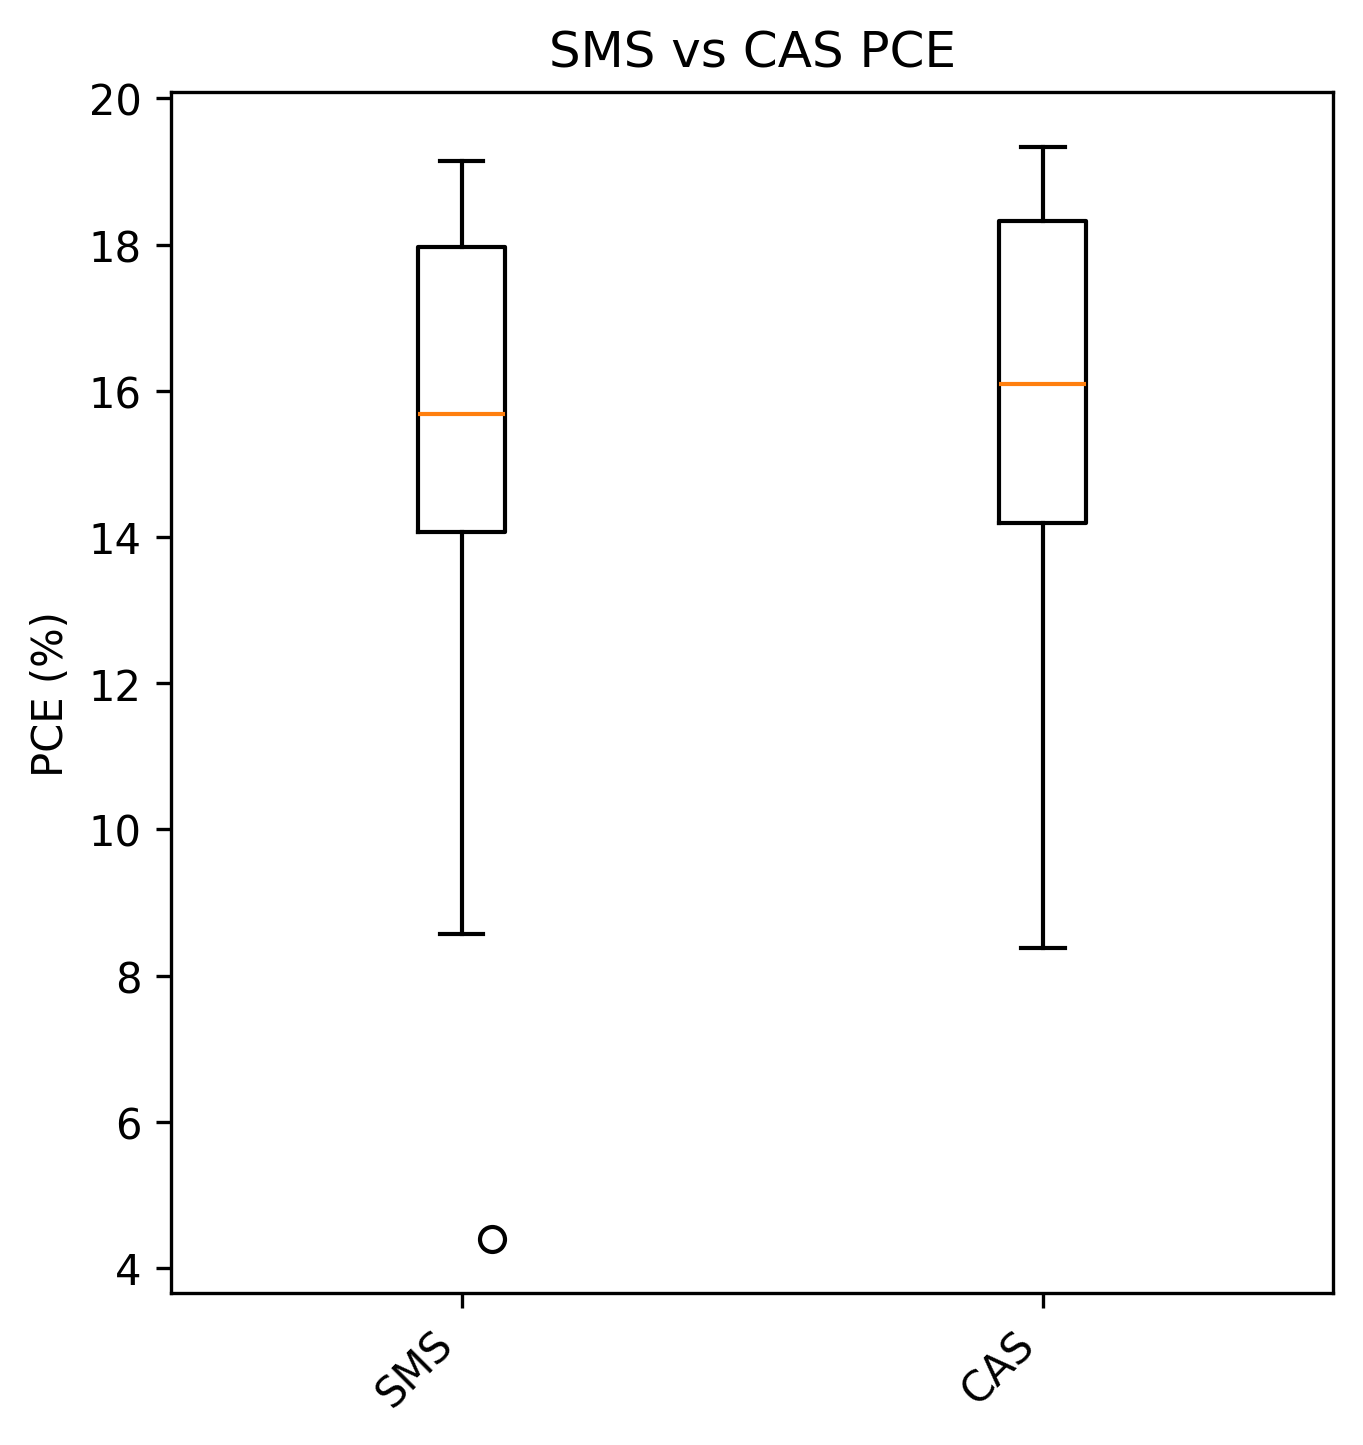

(1500, 1560)
(1500, 1560)


In [14]:

box_plot = [average_sms, average_cas]
labels = ["SMS", "CAS"]

# Optional: compute stats using matplotlib's utility
stats = boxplot_stats(box_plot)

FIGSIZE = (5, 5.2)     # e.g. 8.6 cm × 6.6 cm  (single-column width)
DPI     = 300
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)
bp = ax.boxplot(box_plot, flierprops=dict(marker='o', markersize=0))

for i, stat in enumerate(stats, start=1):
	outliers = stat['fliers']  # already identified!

	if len(outliers) > 0:
		jitter = 0.2 * (np.random.rand(len(outliers)) - 0.5)  # random horizontal spread
		x_positions = np.full(len(outliers), i) + jitter
		ax.scatter(x_positions, outliers, color='white', edgecolor='black', zorder=3)

# Label the x-axis
ax.set_xticks([1, 2])
ax.set_title("SMS vs CAS PCE")
ax.set_ylabel("PCE (%)")
ax.set_xticklabels(labels, rotation=45, ha='right')

fig.savefig("Comparison_PCE_BoxPlot.png", dpi=DPI, bbox_inches=None,   # make sure nothing trims your canvas
            pad_inches=0)
plt.show()
print(fig.canvas.get_width_height())

from PIL import Image
im = Image.open("Comparison_PCE_BoxPlot.png")
print(im.size)


In [21]:
import numpy as np
from scipy import stats

plot_range = [x for x in range(8)]
printouts = []
all_diff = []
average_sms = []
average_cas = []
average_diff_device = []
plot_size = (10,4)
for cas, ss_file in zip(cas_files, sms_files):
	abs_diff, temp_sms, temp_cas = plot_difference(cas, ss_file, plot_range, plot_size = plot_size, remove_outliers=False, roll = 0, plot = False, time_limit=1)
	sms = np.mean(temp_sms)
	cas = np.mean(temp_cas)
	device_diff = abs(sms - cas)
	average_diff_device.append(device_diff)

	all_diff.extend(abs_diff)
	average_sms.extend(temp_sms)
	average_cas.extend(temp_cas)
	# print("sms:" ,temp_sms)
	# print("lit:" ,temp_cas)
	if cas and ss_file:
		try:
			printouts.append([np.min(abs_diff), np.argmin(abs_diff), np.mean(abs_diff), device_diff])

		except:
			pass

average_sms = np.asarray(average_sms)
average_cas = np.asarray(average_cas)
average_diff = average_sms - average_cas


bias = average_diff.mean()
sd   = average_diff.std(ddof=1)
rmse = np.sqrt((average_diff**2).mean())
ci95 = stats.t.interval(0.95, len(average_diff)-1, loc=bias, scale=sd/np.sqrt(len(average_diff)))
loa  = (bias - 1.96*sd, bias + 1.96*sd)
ci95 = (round(ci95[0], 4), round(ci95[1], 4))
loa  = (round(loa[0],  4), round(loa[1],  4))
print(f"PCE bias = {bias:.4f}")
print(f"PCE sd   = {sd:.4f}")
print(f"PCE rmse = {rmse:.4f}")
print(f"PCE ci95 = {ci95}")
print(f"PCE loa  = {loa}")
print()


# PCE bias = -0.0278
# PCE sd   = 1.7007
# PCE rmse = 1.6723
# PCE ci95 = (-0.662819110734372, 0.6072758972374629)
# PCE loa  = (-3.3611209689704675, 3.3055777554735584)


PCE bias = -0.4478
PCE sd   = 1.5964
PCE rmse = 1.6322
PCE ci95 = (-1.0439, 0.1483)
PCE loa  = (-3.5767, 2.6811)



In [26]:
errors = []
for i in range(8):
	plt.figure(figsize=plot_size)
	plt.ylim(bottom = -0, top = max_pce)
	plt.xlabel('Time [min]')
	plt.grid()

	plt.ylabel('PCE [%]')
	plt.subplots_adjust(left=0.086,
						bottom=0.06,
						right=0.844,
						top=0.927,
						wspace=0.2,
						hspace=0.2)
	percent_error = float("inf")

	lineName = "PCE" + str(i + 1)
	if ss_file_path:
		plt.plot(time,data[:,i], label = lineName)
	if cas_time:
		plt.plot(cas_time[i], cas_pce[i], label = "cas" + str(i+1))
	if ss_file_path and cas_time:
		second_half_cas = cas_pce[i][len(cas_pce[i]) // 2:]
		average_second_half_cas = np.mean(second_half_cas)

		second_half = data[:,i][len(data[:,i]) // 2:]
		average_second_half = np.mean(second_half)

		percent_error = abs(average_second_half - average_second_half_cas) / abs(average_second_half_cas) * 100

	labelLines(plt.gca().get_lines(), zorder=2.5)
	plt.title("Percent Error: "+ str(percent_error))
	plt.legend(bbox_to_anchor=(1.15, 1))
for idx, i in enumerate(errors):
	print(idx+1, i)

NameError: name 'max_pce' is not defined

<Figure size 1000x400 with 0 Axes>

In [ ]:

cas_directory = ""
cas_directory = r"C:\Users\achen\Dropbox\code\Stability-Setup\data\Mar-4-2025 4 device test\2025-03-04-- cas New PCB 4 Device comparison\devices\device_4"

all_files = []

if cas_directory != "":
	for root, dirs, files in os.walk(cas_directory):
		for file in files:
			if file.endswith('.csv'):
				file_path = os.path.join(root, file)
				all_files.append(file_path)


cas_pce = []
cas_time = []

# Process each file



In [ ]:
#plot cas uneven length

cas_directory = ""
cas_directory = r"C:\Users\achen\Dropbox\code\Stability-Setup\data\2024-11-06 --cas vs stability setup long test\nov6_2024 test 1\devices"



def process_files(cas_directory, all_files, pattern):
	all_files = []

	if cas_directory != "":
		for root, dirs, files in os.walk(cas_directory):
			for file in files:
				if file.endswith('.csv'):
					file_path = os.path.join(root, file)
					all_files.append(file_path)

	times = []
	pces = []
	for file_path in all_files:
		if pattern in file_path:
			try:
				data = np.genfromtxt(
					file_path,
					delimiter=',',
					comments='#',
					skip_header=0,
					encoding='cp1252'  # Specify the correct encoding
				)
				pce = (data[:, 1] * data[:, 2] / 1000) / (0.1 * 0.128) * 100
				times.append(data[:, 0])
				pces.append(pce)
			except Exception as e:
				print(f"Error processing {file_path}: {e}")

	pces = pces[::-1]
	return times, pces

def calculate_second_half_averages(pces):
	averages = []
	for pce in pces[:8]:  # Limit to first 8 files, as per the original code
		second_half = pce[len(pce) // 2:]
		averages.append(np.mean(second_half))
	return averages

# Process files for each pattern
cas_time1, cas_pce1 = process_files(cas_directory, all_files, "_3_0")
cas_time2, cas_pce2 = process_files(cas_directory, all_files, "_7_0")

# Calculate averages for each pattern
cas_beginning_avg = calculate_second_half_averages(cas_pce1)
cas_ending_avg = calculate_second_half_averages(cas_pce2)

print(cas_beginning_avg)
print(cas_ending_avg)


data = []

ss_file_path = ""
ss_file_path = r"C:\Users\achen\Dropbox\code\Stability-Setup\data\2024-11-06 --cas vs stability setup long test\Nov-06-2024 13_50_53\Nov-06-2024 13_50_53ID2PnO.csv"
if ss_file_path != "":
	arr = np.loadtxt(ss_file_path,
						delimiter=",",
						dtype=str)


	headers = arr[6,:]
	header_dict = {value: index for index, value in enumerate(headers)}
	pce_indicies = [header_dict[value] for value in header_dict if "PCE" in value]
	arr = arr[7:, :]

	time = np.array(arr[:,header_dict["Time"]]).astype('float')
	time/=60
	pce_list = np.array(arr)
	pce_list = pce_list[:, pce_indicies]
	# pce_list = pce_list[:,0:-1]
	for i in range(len(pce_list)):
		pce_list[i] = [float(j) if j != " ovf" else 0.0 for j in pce_list[i]]
		pce_list[i] = [float(j) if j != "nan" else 0.0 for j in pce_list[i]]

	pce_list = pce_list.astype(float)

	data = pce_list #np.array(data).T
	# data *= 2.048 # comment line if not using mask

# min_time = min(time)*0.99
# max_time = max(time)*1.01
plot_size = (12,8)
min_pce = 0
max_pce = 15

plt.figure(figsize=plot_size)
# plt.xlim(min_time,max_time)
plt.ylim(bottom = min_pce, top = max_pce)
plt.xlabel('Time [min]')
plt.grid()

plt.ylabel('PCE [%]')
plt.subplots_adjust(left=0.086,
					bottom=0.06,
					right=0.844,
					top=0.927,
					wspace=0.2,
					hspace=0.2)

errors = []

for i in range(8):
	lineName = "PCE" + str(i + 1)
	# print(np.array(pce_list[i]))
	if data != []:
		plt.plot(time,data[:,i], label = lineName)
	if i < len(cas_beginning_avg) and i < len(cas_ending_avg):
		# Calculate straight line
		y_values = [
			cas_beginning_avg[i],
			cas_ending_avg[i]
		]
		print(y_values)
		x_values = [time[0], time[-1]]
		plt.plot(x_values, y_values, linestyle="--", label=f"cas {i + 1}")

print(np.mean(errors))

lines = plt.gca().get_lines()
x_min, x_max = plt.xlim()
num_lines = len(lines)
xvals = np.linspace(x_min + 0.1 * (x_max - x_min), x_max - 0.1 * (x_max - x_min), num_lines)
bold_font = FontProperties(weight='medium')
labelLines(
	lines,
	xvals=xvals,
	zorder=2.5,
	align=False,
	fontsize=11,
	fontproperties=bold_font
)
plt.legend(bbox_to_anchor=(1.15, 1))


In [ ]:
errors = []
for i in range(8):
	plt.figure(figsize=plot_size)
	plt.ylim(bottom = -0, top = max_pce)
	plt.xlabel('Time [min]')
	plt.grid()

	plt.ylabel('PCE [%]')
	plt.subplots_adjust(left=0.086,
						bottom=0.06,
						right=0.844,
						top=0.927,
						wspace=0.2,
						hspace=0.2)


	lineName = "PCE" + str(i + 1)
	# print(np.array(pce_list[i]))
	plt.plot(time,data[:,i], label = lineName)
	if i < len(cas_beginning_avg) and i < len(cas_ending_avg):
		# Calculate straight line
		y_values = [
			cas_beginning_avg[i],
			cas_ending_avg[i]
		]
		x_values = [time[0], time[-1]]
		plt.plot(x_values, y_values, linestyle="--", label=f"cas {i + 1}")

	last_portion = data[:,i][99*len(data[:,i]) // 100:]
	average_last_ss = np.mean(last_portion)

	percent_error = abs(average_last_ss - cas_ending_avg[i]) / abs(cas_ending_avg[i]) * 100
	errors.append(percent_error)

	labelLines(plt.gca().get_lines(), zorder=2.5)
	plt.title("Percent Error for final result: "+ str(percent_error))
	plt.legend(bbox_to_anchor=(1.15, 1))


for idx, i in enumerate(errors):
	print(idx+1, i)

In [ ]:
def plot_cas_only(cas_directory, pattern):
	# cas_directory = ""

	all_files = []

	if cas_directory != "":
		for root, dirs, files in os.walk(cas_directory):
			for file in files:
				if file.endswith('.csv'):
					file_path = os.path.join(root, file)
					all_files.append(file_path)


	cas_pce = []
	cas_time = []

	# Process each file
	for file_path in all_files:
		if pattern in file_path:
			try:
				data = np.genfromtxt(
					file_path,
					delimiter=',',
					comments='#',
					skip_header=0,
					encoding='cp1252'  # Specify the correct encoding
				)
				pce = (data[:, 1] * data[:, 2] /1000) / (0.1*0.128)*100
				# data_with_pce= np.column_stack((data, pce))
				cas_time.append(data[:,0])
				cas_pce.append(pce)
			except Exception as e:
				print(f"Error processing {file_path}: {e}")

	cas_pce = cas_pce[::-1]
	cas_time = cas_time[::-1]


	plt.figure(figsize=plot_size)
	plt.xlabel('Time [sec]')
	plt.grid()

	plt.ylabel('PCE [%]')
	plt.subplots_adjust(left=0.086,
						bottom=0.06,
						right=0.844,
						top=0.927,
						wspace=0.2,
						hspace=0.2)

	errors = []

	for i in range(8):
		if cas_time:
			plt.plot(cas_time[i], cas_pce[i], label = "cas" + str(i+1))
			second_half_cas = cas_pce[i][len(cas_pce[i]) // 2:]
			average_second_half_cas = np.mean(second_half_cas)
			print(average_second_half_cas)

	print(np.mean(errors))

	lines = plt.gca().get_lines()
	x_min, x_max = plt.xlim()
	num_lines = len(lines)
	xvals = np.linspace(x_min + 0.1 * (x_max - x_min), x_max - 0.1 * (x_max - x_min), num_lines)
	bold_font = FontProperties(weight='medium')
	labelLines(
		lines,
		xvals=xvals,
		zorder=2.5,
		align=False,
		fontsize=11,
		fontproperties=bold_font
	)
	plt.legend(bbox_to_anchor=(1.15, 1))
plot_cas_only(r"C:\Users\achen\Dropbox\code\Stability-Setup\data\2024-11-06 --cas vs stability setup long test\nov6_2024 test 1\devices", "_3_0")
plot_cas_only(r"C:\Users\achen\Dropbox\code\Stability-Setup\data\2024-11-06 --cas vs stability setup long test\nov6_2024 test 1\devices", "_7_0")